# Helmholtz 1D: Ideal TV & Coarsening - Level 0->1
Suppose we drove the bootstrap process to convergence and obtained the ideal test vector set. Can we verify that in this case we fit a good interpolation with our current LS fitting process? This experiment attempts to check this, in a two-level setting (level 0->1). We test our interpolation by running two-level cycles for solving $A x = b$, and our ideal test vectors are near-null-space eigenvectors (since they are globally algebraically smooth, we can allow ourselves to run a two-level solver, not just a relaxation cycle.

## Discretization
We use the 5-point finite difference $A^h = [-1, 16, -30 + 12 (kh)^2, 16, -1]$. 

In this experiment we use a fixed periodic domain with $n=96$ points and a small various $kh$ values. We use the idealized test functions = lowest eigenvectors of $A^h$.

In [312]:
import collections
import logging
import numpy as np
import matplotlib.pyplot as plt
import helmholtz as hm
import helmholtz.analysis
import pandas as pd
import scipy.sparse
import sklearn.metrics.pairwise
import sys
from numpy.ma.testutils import assert_array_almost_equal
from scipy.linalg import eig, norm, svd
from scipy.sparse.linalg import eigs

%load_ext autoreload
%autoreload 2

np.set_printoptions(linewidth=500, precision=2, suppress=True, threshold=100000)
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)-8s %(message)s",
                    datefmt="%a, %d %b %Y %H:%M:%S")

logger = logging.getLogger("main")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Finest-level Eigenvalues

In [313]:
# Fixed seed for reproducible results.
np.random.seed(0)

n = 96
num_examples = 15
num_windows = 10
threshold = 0.1
kh = 0.5
num_test_examples = 5

# Mock cycle #relaxations per cycle.
nu_values = np.arange(1, 12, dtype=int)

Smallest-magnitude eigenvalue -0.02393225657483029


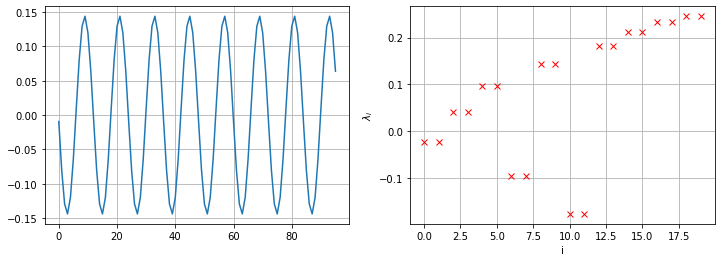

In [314]:
a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()

lam, v = eig(a.todense())
lam = np.real(lam)
ind = np.argsort(np.abs(lam))
lam = lam[ind]
v = v[:, ind]
print("Smallest-magnitude eigenvalue", lam[0])

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
ax.plot(v[:, 0]);
ax.grid(True)

ax = axs[1]
ax.plot(lam[:20], "rx")
ax.grid(True)
ax.set_xlabel("i")
ax.set_ylabel(r"$\lambda_i$");

## Test Vectors
* Relaxed vectors to calculate the SVD and $R$.
* Idealized TV = 8 lowest Eigenvectors and 2 points to determine $P$ by LS.

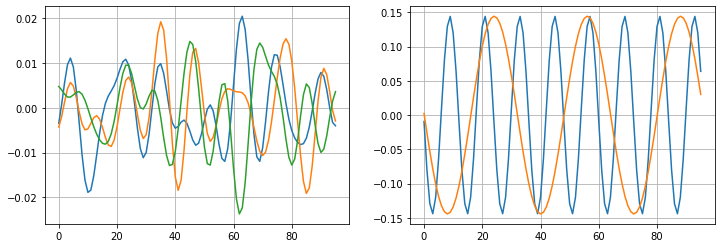

In [333]:
a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()
level = hm.setup.hierarchy.create_finest_level(a)

x = hm.solve.run.random_test_matrix((n,), num_examples=num_examples)
b = np.zeros_like(x)
x_relaxed, _ = hm.solve.run.run_iterative_method(
   level.operator, lambda x: level.relax(x, b), x, num_sweeps=100)

x_ideal, lam = helmholtz.analysis.ideal.ideal_tv(a, num_examples)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Relaxed vectors.
ax = axs[0]
ax.plot(x_relaxed[:, 0]);
ax.plot(x_relaxed[:, 1]);
ax.plot(x_relaxed[:, 2]);
ax.grid(True)

ax = axs[1]
ax.plot(x_ideal[:, 0]);
ax.plot(x_ideal[:, -1]);
ax.grid(True);

### Coarsening Operator

In [336]:
r, aggregates, nc, energy_error = hm.setup.coarsening.create_coarsening_domain(
    x_relaxed, threshold=threshold)
print(r.shape)
logger.info("Agg {}".format(np.array([len(aggregate) for aggregate in aggregates])))
logger.info("nc  {}".format(nc))
logger.info("Energy error mean {:.4f} max {:.4f}".format(np.mean(energy_error), np.max(energy_error)))

(48, 96)
INFO     Agg [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
INFO     nc  [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
INFO     Energy error mean 0.0545 max 0.0858


In [337]:
mock_conv_factor = np.array(
    [hm.setup.auto_setup.mock_cycle_conv_factor(level, r, nu) for nu in np.arange(1, 9, dtype=int)])
logger.info("Mock cycle conv factor {}".format(np.array2string(mock_conv_factor, precision=3)))

INFO     Mock cycle conv factor [0.565 0.315 0.187 0.143 0.146 0.123 0.085 0.067]


### Interpolation by Least-Squares

In [338]:
x = x_ideal
p, fit_error, val_error, test_error, alpha_opt = \
    hm.setup.interpolation.create_interpolation_least_squares_auto_nbhrs(
    x, a, r, neighborhood="aggregate", num_test_examples=num_test_examples)
num_fit_examples = x.shape[1] - num_test_examples
x_fit, x_test = x[:, :int(0.8 * num_fit_examples)], x[:, -num_test_examples:]
for title, x_set in (("fit", x_fit), ("test", x_test)):
    error = norm(x_set - p.dot(r.dot(x_set)), axis=0) / norm(x_set, axis=0)
    error_a = norm(a.dot(x_set - p.dot(r.dot(x_set))), axis=0) / norm(x_set, axis=0)
    logger.info("{:<4s} set size {:<2d} P L2 error mean {:.2f} max {:.2f} A error mean {:.2f} max {:.2f}".format(
        title, len(error), np.mean(error), np.max(error), np.mean(error_a), np.max(error_a)))

p0 = p
multilevel = hm.hierarchy.multilevel.Multilevel(level)
coarse_level = hm.setup.hierarchy.create_coarse_level(level.a, level.b, r, p)
multilevel.level.append(coarse_level)

INFO     fit  set size 8  P L2 error mean 0.05 max 0.07 A error mean 0.13 max 0.24
INFO     test set size 5  P L2 error mean 0.10 max 0.11 A error mean 0.29 max 0.40


In [342]:
# Two-level rate doesn't get better than ~0.35.
two_level_cycle = lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, 0, 6).run(x)
y, conv_factor = hm.solve.run.run_iterative_method(level.operator, two_level_cycle,
                                                np.random.random((a.shape[0], )), 10,
                                                print_frequency=1)
y = y.flatten()
print("Conv Factor {:.5f}".format(conv_factor))

INFO         0 |r| 9.79008968e+00 RER 1.66350
INFO         1 |r| 9.18560124e-01 (0.09383) RER 0.34092 (0.20494) 2.69432
INFO         2 |r| 2.36826766e-01 (0.25782) RER 0.37137 (1.08930) 0.63772
INFO         3 |r| 6.81180008e-02 (0.28763) RER 0.30847 (0.83063) 0.22083
INFO         4 |r| 2.19141673e-02 (0.32171) RER 0.32132 (1.04167) 0.06820
INFO         5 |r| 7.14425520e-03 (0.32601) RER 0.31737 (0.98769) 0.02251
INFO         6 |r| 2.50564852e-03 (0.35072) RER 0.32725 (1.03115) 0.00766
INFO         7 |r| 8.92398240e-04 (0.35615) RER 0.32845 (1.00365) 0.00272
INFO         8 |r| 3.26244383e-04 (0.36558) RER 0.33432 (1.01786) 0.00098
INFO         9 |r| 1.20267917e-04 (0.36864) RER 0.34514 (1.03238) 0.00035
INFO        10 |r| 4.48794783e-05 (0.37316) RER 0.35310 (1.02305) 0.00013
Conv Factor 0.36276


P L2 error 0.24 A error 0.92


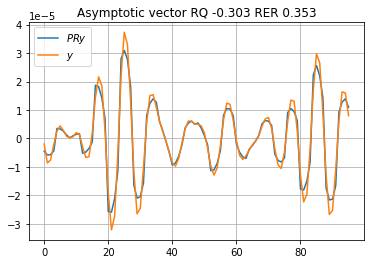

In [344]:
# Asymptotic vector of 2-level relaxation cycle at level 1 is smooth but not the AZM.
p = coarse_level.p
r = coarse_level.r
correction = p.dot(r.dot(y))
print("P L2 error {:.2f} A error {:.2f}".format(
      norm(y - correction) / norm(y), norm(a.dot(y - correction)) / norm(y)))

plt.plot(correction, label="$P R y$")
plt.plot(y, label="$y$")
plt.title("Asymptotic vector RQ {:.3f} RER {:.3f}".format(level.rq(y), norm(level.operator(y))/norm(y)))
plt.legend()
plt.grid(True);

### Two-level Predition by Eigenvalues of the Symmetric Relaxation Error Propagator
This is yet another two-level convergence predictor. It is a strict lower bound if a symmetric relaxation is used.

48
nu 1 conv factor 0.52
nu 2 conv factor 0.27
nu 3 conv factor 0.14


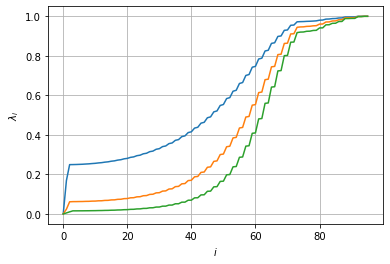

In [348]:
nc = coarse_level.a.shape[1]
print(nc)
for num_sweeps in range(1, 4):
    relaxer = hm.solve.relax.SymmetricKaczmarzRelaxer(a, scipy.sparse.eye(a.shape[0]), num_sweeps=num_sweeps)
    R = relaxer.step(np.eye(a.shape[0]), np.zeros(a.shape[0]))
    lam = np.sort(np.real(eig(R)[0]))
    plt.plot(lam)
    plt.grid(True)
    print("nu {} conv factor {:.2f}".format(num_sweeps, lam[nc]))
    plt.xlabel(r"$i$")
    plt.ylabel(r"$\lambda_i$")

In [352]:
# Two-level test with symmetric Kaczmarz sweeps.
for num_sweeps in range(1, 4):
    print("nu", num_sweeps)
    symmetric_relaxer = hm.solve.relax.SymmetricKaczmarzRelaxer(a, scipy.sparse.eye(a.shape[0]), num_sweeps=num_sweeps)
    symmetric_level = hm.hierarchy.multilevel.Level.create_finest_level(a, symmetric_relaxer)
    multilevel.level[0] = symmetric_level

    two_level_cycle = lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, 0, 1).run(x)
    y, conv_factor = hm.solve.run.run_iterative_method(level.operator, two_level_cycle,
                                                    np.random.random((a.shape[0], )), 10,
                                                    print_frequency=1)
    y = y.flatten()
    print("Conv Factor {:.5f}".format(conv_factor))
multilevel.level[0] = level

nu 1
INFO         0 |r| 6.73639047e+00 RER 1.25212
INFO         1 |r| 2.29255784e+00 (0.34032) RER 0.88590 (0.70752) 2.58784
INFO         2 |r| 1.01284008e+00 (0.44179) RER 0.85072 (0.96029) 1.19057
INFO         3 |r| 4.88485847e-01 (0.48229) RER 0.81323 (0.95593) 0.60067
INFO         4 |r| 2.50907280e-01 (0.51364) RER 0.77674 (0.95513) 0.32303
INFO         5 |r| 1.34354779e-01 (0.53548) RER 0.74402 (0.95787) 0.18058
INFO         6 |r| 7.39807657e-02 (0.55064) RER 0.71625 (0.96268) 0.10329
INFO         7 |r| 4.15479808e-02 (0.56161) RER 0.69343 (0.96815) 0.05992
INFO         8 |r| 2.36762731e-02 (0.56985) RER 0.67500 (0.97342) 0.03508
INFO         9 |r| 1.36426554e-02 (0.57622) RER 0.66020 (0.97808) 0.02066
INFO        10 |r| 7.92922370e-03 (0.58121) RER 0.64833 (0.98201) 0.01223
Conv Factor 0.56780
nu 2
INFO         0 |r| 8.14222081e+00 RER 1.39714
INFO         1 |r| 1.30929028e+00 (0.16080) RER 0.53543 (0.38323) 2.44533
INFO         2 |r| 3.48525684e-01 (0.26619) RER 0.45366 (0.84729

Again, we see that we cannot get better than $0.35$.

## Add Slowest Two-level Vector $y$ to TV Set and Update $P$

In [354]:
# Prepend the vector y to x, since our folds are sorted as fit, then test.
x = np.concatenate((y[:, None], x), axis=1)
logger.info("Added vector to TF set, #examples {}".format(x.shape[1]))

INFO     Added vector to TF set, #examples 16


In [355]:
p, fit_error, val_error, test_error, alpha_opt = \
    hm.setup.interpolation.create_interpolation_least_squares_auto_nbhrs(
    x, a, r, neighborhood="aggregate", num_test_examples=num_test_examples)
x_fit, x_test = x[:, :-num_test_examples], x[:, -num_test_examples:]
for title, x_set in (("fit", x_fit), ("test", x_test)):
    error = norm(x_set - p.dot(r.dot(x_set)), axis=0) / norm(x_set, axis=0)
    error_a = norm(a.dot(x_set - p.dot(r.dot(x_set))), axis=0) / norm(x_set, axis=0)
    logger.info("{:<4s} set size {:<2d} P L2 error mean {:.2f} max {:.2f} A error mean {:.2f} max {:.2f}".format(
        title, len(error), np.mean(error), np.max(error), np.mean(error_a), np.max(error_a)))

p1 = p
multilevel = hm.hierarchy.multilevel.Multilevel(level)
coarse_level = hm.setup.hierarchy.create_coarse_level(level.a, level.b, r, p)
multilevel.level.append(coarse_level)

p = coarse_level.p
r = coarse_level.r
correction = p.dot(r.dot(y))
print("Slowest vector (y), P L2 error {:.2f} A error {:.2f}".format(
      norm(y - correction) / norm(y), norm(a.dot(y - correction)) / norm(y)))

INFO     fit  set size 11 P L2 error mean 0.06 max 0.24 A error mean 0.22 max 0.95
INFO     test set size 5  P L2 error mean 0.10 max 0.11 A error mean 0.30 max 0.41
Slowest vector (y), P L2 error 0.24 A error 0.95


Adding the vector to the plain LS without weighting (e.g., an infinite weight for $y$) didn't reduce its interpolation error.

In [353]:
two_level_cycle = lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, 0, 6).run(x)
y, conv_factor = hm.solve.run.run_iterative_method(level.operator, two_level_cycle,
                                                np.random.random((a.shape[0], )), 10,
                                                print_frequency=1)
y = y.flatten()
print("Conv Factor {:.5f}".format(conv_factor))

INFO         0 |r| 8.67882905e+00 RER 1.67328
INFO         1 |r| 8.63834677e-01 (0.09953) RER 0.36777 (0.21979) 2.34882
INFO         2 |r| 2.29957388e-01 (0.26621) RER 0.35499 (0.96523) 0.64779
INFO         3 |r| 6.87960900e-02 (0.29917) RER 0.29179 (0.82198) 0.23577
INFO         4 |r| 2.28564433e-02 (0.33223) RER 0.37553 (1.28699) 0.06086
INFO         5 |r| 7.63359883e-03 (0.33398) RER 0.33328 (0.88747) 0.02290
INFO         6 |r| 2.74628405e-03 (0.35976) RER 0.37890 (1.13689) 0.00725
INFO         7 |r| 9.91516266e-04 (0.36104) RER 0.36725 (0.96926) 0.00270
INFO         8 |r| 3.72241581e-04 (0.37543) RER 0.36839 (1.00310) 0.00101
INFO         9 |r| 1.40306015e-04 (0.37692) RER 0.35730 (0.96990) 0.00039
INFO        10 |r| 5.39421117e-05 (0.38446) RER 0.35093 (0.98218) 0.00015
Conv Factor 0.37140


P L2 error 0.25 A error 0.98


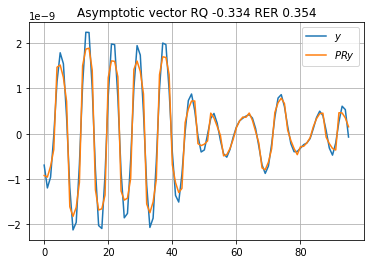

In [327]:
# Asymptotic vector of 2-level relaxation cycle at level 1 is still smooth.
p = coarse_level.p
r = coarse_level.r
plt.plot(y, label="$y$")
plt.title("Asymptotic vector RQ {:.3f} RER {:.3f}".format(level.rq(y), norm(level.operator(y))/norm(y)))
correction = p.dot(r.dot(y))
plt.plot(correction, label="$P R y$")
plt.legend()
plt.grid(True);
print("P L2 error {:.2f} A error {:.2f}".format(
      norm(y - correction) / norm(y), norm(a.dot(y - correction)) / norm(y)))

## Conclusions
* Adding the slowest two-level error to the plain LS without weighting (e.g., an infinite weight for $y$) didn't reduce its interpolation error. We could give it infinite weight and increase the caliber by 1, performing either a LS or a Kaczmarz update of $P$.